In [121]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import math
import torch.nn.functional as F
from tqdm import tqdm

In [133]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE
PATCH_SIZE = 16
BATCH_SIZE = 32

Files already downloaded and verified


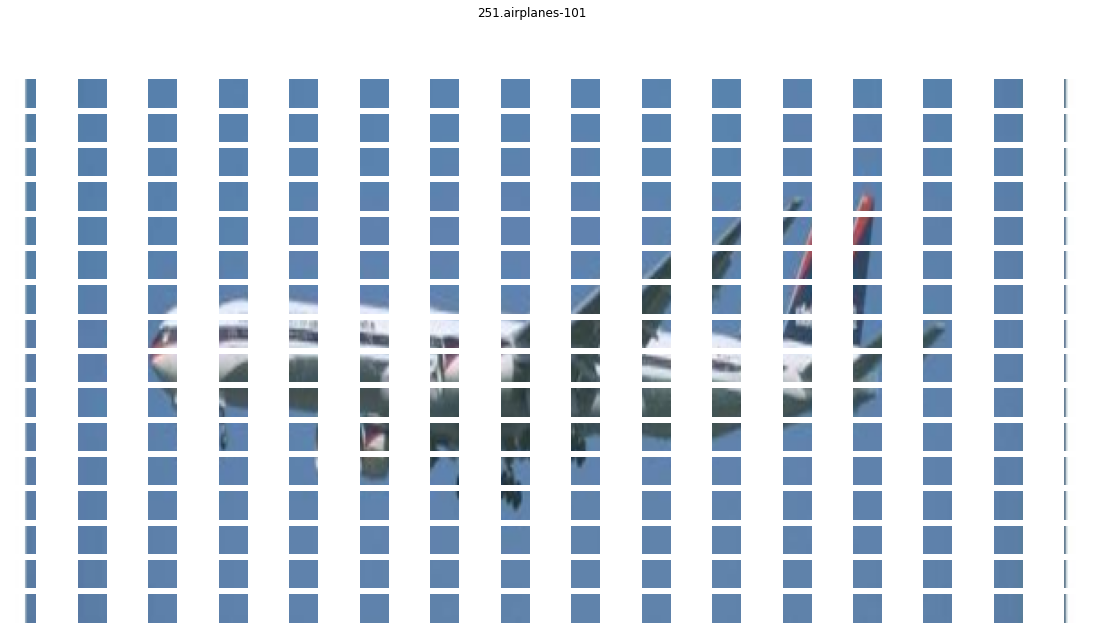

In [143]:
class PatchCollate:

    def __init__(self, kernel, stride):
        self.kernel, self.stride = kernel, stride

    def __call__(self, x):
        x, labels = torch.utils.data.default_collate(x)
        b, c, _, _ = x.shape
        windows = x.unfold(2, self.kernel, self.stride).unfold(3, self.kernel, self.stride).permute(0, 2, 3, 1, 4, 5)
        return windows.reshape(b, -1, c, windows.shape[-2], windows.shape[-1]), labels
    

class ToRGB:

    def __init__(self):
        pass

    def __call__(self, img):
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img


def test_image(loader, idx_map):
    imgs, labels = next(iter(train_loader))
    output, output_label = imgs[0], idx_map[labels[0].item()]
    fig, ax = plt.subplots(nrows=16, ncols=16, figsize=(20, 10))
    ax = ax.flatten()
    for patch, axis in zip(output, ax):
        axis.imshow(patch.permute(1, 2, 0))
        axis.axis(False)
    fig.suptitle(output_label)
    plt.show()


T = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ToRGB()
])
dataset = datasets.Caltech256("./dataset", download=True, transform=T)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_SIZE, TEST_SIZE])
class_to_idx = {c: i for i, c in enumerate(dataset.categories)}
idx_to_class = {value: key for key, value in class_to_idx.items()}

patch_collate_fn = PatchCollate(PATCH_SIZE, PATCH_SIZE)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=patch_collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE * 10, shuffle=True, collate_fn=patch_collate_fn)

test_image(train_loader, idx_to_class)